In [1]:
#
# In this notebooks PSs are identified and plotted
#
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import wget
from scipy.ndimage import label
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from os.path import basename
from src.regions import *
from src.plotting import * 
from src.pf_stats import *

In [16]:
# Load region to pull examples from
regions = [
    afc_region(), 
    cio_region(), 
    wmp_region(), 
]

pf_stats = pd.concat(
    [load_pf_stats(r, maxpr_min=5) for r in regions]
)

In [17]:
area = pf_stats['num_pixels']*25
loc = pf_stats['rainiest_10mmhr_cluster_precip_8conn'] / pf_stats['total_precip']
maxpr = pf_stats['max_precip']

high_area_id = (1675<=area) & (area<=1700)
low_area_id = (300<=area) & (area<=350)

high_loc_id = (0.75<=loc) & (loc<=0.77)
low_loc_id = (0.2<=loc) & (loc<=0.25)

extreme_id = maxpr >= 80

regime_dict = {
    'high_area_high_loc': pf_stats[high_area_id & high_loc_id & extreme_id],
    'high_area_low_loc' : pf_stats[high_area_id & low_loc_id & extreme_id],
    # 'low_area_high_loc' : pf_stats[low_area_id  & high_loc_id & extreme_id],
    # 'low_area_low_loc'  : pf_stats[low_area_id  & low_loc_id & extreme_id]
}


TypeError: No numeric data to plot.

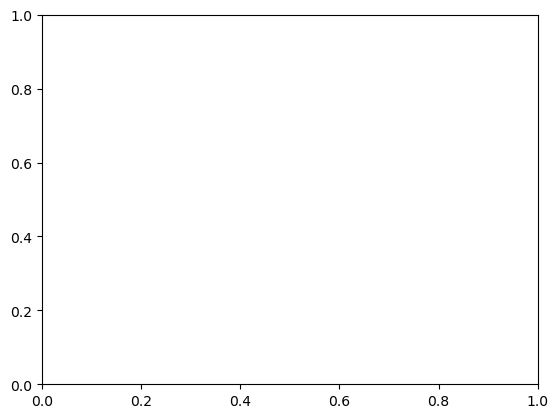

In [18]:
for regime, df in regime_dict.items():
    file = pf_stats['gpm_filename'].iloc[0]
    pf_id = pf_stats['feature_id'].iloc[0]
    region_name = file.split('_')[-1].split('.')[0]
    url = f"http://gpm.atmos.washington.edu/{'/'.join(file.split('/')[5:])}"
    out_filename = f'/Users/pedro/extreme_precipitation_in_gpm/data/example_data/{regime}.nc'
    wget.download(url, out_filename)

    swath_data = xr.open_dataset(out_filename).squeeze('time')
    
    rainy_mask = swath_data['near_surf_rain'] >= 1

    structure = [[1,1,1],[1,1,1],[1,1,1]]
    pf_mask = label(rainy_mask, structure=structure)[0]==pf_id
    pf_mask = rainy_mask.copy(data=pf_mask)

    pf_data = swath_data.where(pf_mask, drop=True)

    fig, ax = plt.subplots()

    pf_data.near_surf_rain.plot(
        ax=ax, 
        cmap=plt.cm.jet, 
        norm=colors.Normalize(vmin=1, vmax=100)
    )
    ax.set_title(regime)
    
    # Highlight pixels >5mm/hr
    precip = swath_data['near_surf_rain']
    mask = precip > 5
    lat_vals = precip.coords['lat'].values
    lon_vals = precip.coords['lon'].values
    LON, LAT = np.meshgrid(lon_vals, lat_vals)

    ax.scatter(
        LON[mask], 
        LAT[mask], 
        s=10,          # marker size
        c='red',       # marker color
        alpha=0.6,     # some transparency
        label='>5mm/hr'
    )


In [21]:
pf_mask

<xarray.DataArray 'near_surf_rain' (lat: 347, lon: 186)> Size: 65kB
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
    time     datetime64[ns] 8B 2015-08-04T23:19:46
  * lon      (lon) float32 744B 132.0 132.1 132.1 132.1 ... 141.1 141.2 141.2
  * lat      (lat) float32 1kB -7.3 -7.25 -7.2 -7.15 -7.1 ... 9.85 9.9 9.95 10.0

In [8]:
pf_data.near_surf_rain

<xarray.DataArray 'near_surf_rain' (lat: 2, lon: 1)> Size: 8B
array([[7.255573 ],
       [1.4351343]], dtype=float32)
Coordinates:
    time     datetime64[ns] 8B 2015-08-04T23:19:46
  * lon      (lon) float32 4B 139.8
  * lat      (lat) float32 8B 7.45 7.5
Attributes:
    units:      mm/hr
    long_name:  Near Surface Rain

In [86]:
swath_data.time

<xarray.DataArray 'time' (time: 1)> Size: 8B
array(['2015-08-04T23:19:46.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 8B 2015-08-04T23:19:46
Attributes:
    standard_name:  time
    long_name:      Data time
    axis:           T
    comment:        2015-08-04T23:19:46Z

In [41]:
'/'.join(file.split('/')[5:])

'v07/WMP/interp_data/2015/07/GPM2Ku7_uw4_20150711.182741_to_20150711.183523_007765_WMP.nc'

In [24]:
# Generate commands to copy files to local 
area = df['num_pixels'] * 25
localization = df['largest_5mmhr_cluster_precip_4conn']/df['total_precip']
hi_loc = (
    df.where(
        (abs(area-(10**(4)))<20)
        & (localization>0.75)
    )
    .dropna()
)

low_loc = (
    df.where(
        (abs(area-(10**(4)))<20)
        & (localization<0.2)
    )
    .dropna()
)

# Output commands to copy/paste
print(f'Found {hi_loc.shape[0]} hi-loc large files')
filename = hi_loc['pf_filename'].iloc[0]
print(
    f'scp pangulo@sun.atmos.washington.edu:{filename} /Users/pedro/extreme_precipitation_in_gpm/data/example_data/hi_loc_pf.nc'
)
print(f'Found {low_loc.shape[0]} low-loc large files')

filename = low_loc['pf_filename'].iloc[0]
print(
    f'scp pangulo@sun.atmos.washington.edu:{filename} /Users/pedro/extreme_precipitation_in_gpm/data/example_data/low_loc_pf.nc'
)

Found 2 hi-loc large files
scp pangulo@sun.atmos.washington.edu:/home/disk/tc/pangulo/gpm_precipitation_feature_database/WMP/2019/06/GPM2Ku7_uw4_20190611.195902_to_20190611.200643_030027_WMP.pf118.complete.PrThresh1.00 /Users/pedro/extreme_precipitation_in_gpm/data/example_data/hi_loc_pf.nc
Found 12 low-loc large files
scp pangulo@sun.atmos.washington.edu:/home/disk/tc/pangulo/gpm_precipitation_feature_database/WMP/2020/07/GPM2Ku7_uw4_20200726.192420_to_20200726.193117_036420_WMP.pf045.complete.PrThresh1.00 /Users/pedro/extreme_precipitation_in_gpm/data/example_data/low_loc_pf.nc


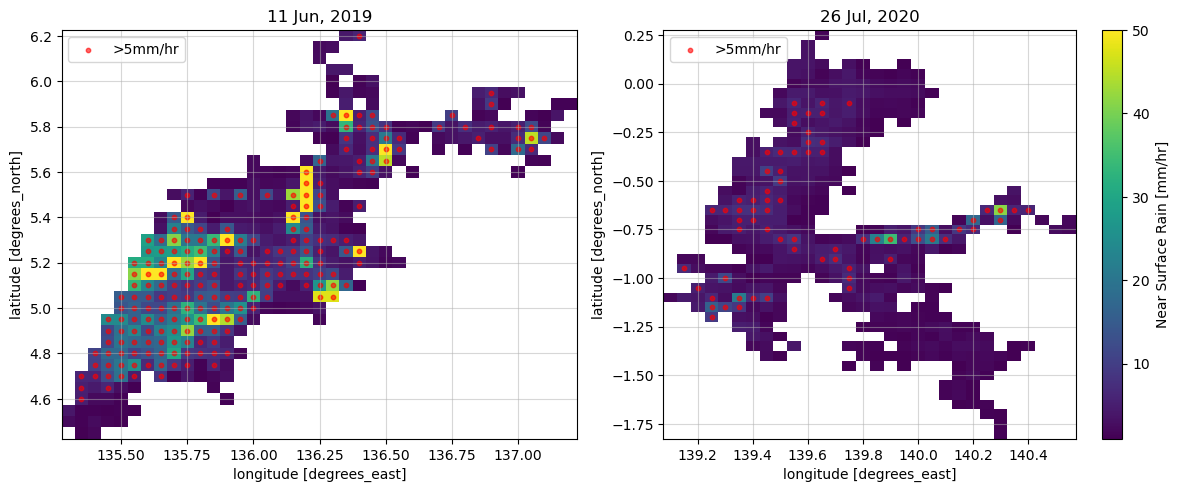

In [25]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr

# Plot the two
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
cmap = plt.cm.viridis.copy()
norm = colors.Normalize(vmin=1, vmax=50)

hi_loc_ds = xr.open_dataset(
    '/Users/pedro/extreme_precipitation_in_gpm/data/example_data/hi_loc_pf.nc'
)
low_loc_ds = xr.open_dataset(
    '/Users/pedro/extreme_precipitation_in_gpm/data/example_data/low_loc_pf.nc'
)

for i, pf in enumerate([hi_loc_ds, low_loc_ds]):
    precip = pf.near_surf_rain
    
    # Plot the main precipitation field
    precip.plot(
        ax=axs[i],
        cmap=cmap, 
        norm=norm,
        add_colorbar=(i == 1)  # for example, add colorbar only on the second plot
    )
    
    # Highlight pixels >5mm/hr
    mask = precip > 5
    lat_vals = precip.coords['lat'].values
    lon_vals = precip.coords['lon'].values
    LON, LAT = np.meshgrid(lon_vals, lat_vals)

    axs[i].scatter(
        LON[mask], 
        LAT[mask], 
        s=10,          # marker size
        c='red',       # marker color
        alpha=0.6,     # some transparency
        label='>5mm/hr'
    )
    
    axs[i].set_title(pf.time.dt.strftime('%d %b, %Y').item())
    axs[i].grid(alpha=0.5)
    axs[i].legend(loc='upper left')
fig.tight_layout(pad=1)
plt.show()
